In [7]:
ROOT = "/users/kcochran/projects/domain_adaptation_nosexchr/"

# shorthand names for each TF
tfs = ["CTCF", "CEBPA", "Hnf4a", "RXRA"]
# plot-acceptable names for each TF
tfs_latex_names = ["CTCF", "CEBPA", "HNF4A", "RXRA"]

# shorthand names for each species
all_trainspecies = ["mm10", "hg38"]
# plot-acceptable names for each species
model_names_dict = {"mm10" : "Mouse", "hg38" : "Human"}
# colors to associate with each species in plots
colors_dict = {"mm10" : "tab:blue", "hg38" : "tab:orange"}
colors_dict = {"mm10" : "#0062B8", "hg38" : "#FF0145"}
# constants to be used in plotting functions
DOT_SIZE = 5
ALPHA = 0.5
AXIS_SIZE = 11
AX_OFFSET = 0.02
TF_TWINAX_OFFSET = 0.35
FIG_SIZE_UNIT = 5
FIG_SIZE_2_by_4 = (FIG_SIZE_UNIT, FIG_SIZE_UNIT * 2)
FIG_SIZE_1_by_4 = (FIG_SIZE_UNIT / 2, FIG_SIZE_UNIT * 2)

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def get_model_log_files(species, tf, DA = False, runs = 5):
    # This function supplies a list of log filenames.
    # Each filename is for the log file for a specific run/replicate.
    # See the scripts run_training.sh and run_DA_training.sh for
    # log file creation (output of model training). See the function
    # get_both_species_auprcs() below for expected log file content.
    log_out_root = ROOT + "logs/"
    
    if DA:
        prefix = log_out_root + "DA_" + species + "_" + tf + "_run"
    else:
        prefix = log_out_root + "BM_" + species + "_" + tf + "_run"
    suffix = ".log"
    
    return [prefix + str(i) + suffix for i in range(1, runs + 1)]

In [10]:
def get_both_species_auprcs(model_out_filename):
    # This function reads in the info stored in a single log file.
    # The log files contain a lot of info/junk, but we only care
    # about the auPRCs for each epoch. Those can be found on lines
    # that start with "auPRC:" and are listed in the file in order
    # of epoch. Each epoch, both the source species' and target
    # species' auPRCs are listed, with the target species' auPRC
    # listed first.
    # This function returns a tuple of two lists: list 1 is the
    # auPRCs across each epoch when the model was evaluated on
    # mouse data; list 2 is the auPRCs across each epoch when the
    # model was evaluated on human data.
    
    if "hg38" in model_out_filename:
        source = "hg38"
        target = "mm10"
    else:
        source = "mm10"
        target = "hg38"
        
    lines = {source : [], target : []}
    line_counter = 0
    with open(model_out_filename) as f:
        # assuming auPRCs are listed by epoch
        # with target species listed first, then source species
        for line in f:
            if line.startswith("auPRC"):
                auprc = float(line.strip().replace("auPRC:\t", ""))
                if line_counter % 2 == 0:
                    lines[target].append(auprc)
                else:
                    lines[source].append(auprc)
                line_counter += 1
               
    assert len(lines["mm10"]) == len(lines["hg38"])
    return lines["mm10"], lines["hg38"]

In [11]:
def auprc_lineplot(mm10_model_files, hg38_model_files, tf_name, plot_index, plot_y_index,
                   y_max = None, title = None):
    # This function creates a single line subplot (to be called repeatedly).
    # Arguments:
    #     - model_files: paths for the log files for all model runs,
    #           for a given TF (output of get_model_log_files())
    #     - tf_name: name of the TF to display on the plot
    #     - plot_index: the top-to-bottom index of the subplot
    #     - plot_y_index: the left-to-right index of the subplot
    #     - y_max: optional, manually set the top limit of the y-axis
    #           for this subplot (default auto-detects max of data plotted)
    #     - title: optional
    ax = plt.gca()
    
    # First, load in the auPRCs across all epochs for all model runs
    # Keep track of the max auPRC so the y-axis limits can be set properly
    # Also keep track of the legend handles to use later
    max_auprc_so_far = 0
    legend_handles = []
    
    for model_out_file in mm10_model_files:
        mm10_auprcs, hg38_auprcs = get_both_species_auprcs(model_out_file)
        if plot_y_index == 0:  # assuming mouse results are in left column
            l1 = ax.plot(range(len(mm10_auprcs)), mm10_auprcs,
                         c = colors_dict["mm10"], alpha = ALPHA)[0]
        else:
            l1 = ax.plot(range(len(hg38_auprcs)), hg38_auprcs,
                         c = colors_dict["mm10"], alpha = ALPHA)[0]
            
    for model_out_file in hg38_model_files:
        mm10_auprcs, hg38_auprcs = get_both_species_auprcs(model_out_file)
        if plot_y_index == 0:  # assuming mouse results are in left column
            l2 = ax.plot(range(len(mm10_auprcs)), mm10_auprcs,
                         c = colors_dict["hg38"], alpha = ALPHA)[0]
        else:
            l2 = ax.plot(range(len(hg38_auprcs)), hg38_auprcs,
                         c = colors_dict["hg38"], alpha = ALPHA)[0] 

        legend_handles = [l1, l2]
        ax.set_xticks([])
        
        # keep trakc of max auPRC seen so far
        if plot_y_index == 0:
            if max_auprc_so_far < max([max_auprc_so_far] + mm10_auprcs):
                max_auprc_so_far = max([max_auprc_so_far] + mm10_auprcs)
        else:
            if max_auprc_so_far < max([max_auprc_so_far] + hg38_auprcs):
                max_auprc_so_far = max([max_auprc_so_far] + hg38_auprcs)
        
    # set top limit of y-axis
    if y_max is None:
        y_max = max_auprc_so_far
    ax.set_ylim( - y_max / 25, y_max + 0.02)
    
    if y_max > 0.4:
        possible_ticks = [num / 10 for num in list(range(0, 11, 2))]
        ticks_to_use = [num for num in possible_ticks if num < y_max]
    else:
        possible_ticks = [num / 10 for num in list(range(0, 11, 1))]
        ticks_to_use = [num for num in possible_ticks if num < y_max]
    
    ax.set_yticks(ticks_to_use)
    ax.set_yticklabels(ticks_to_use)
    
    # if we are plotting a subplot in the leftmost column...
    if plot_y_index == 0:
        # label the y-axis with "auPRC"
        ax.set_ylabel("auPRC", fontsize = AXIS_SIZE)
        
        # add the TF name label to the far left of the plot
        ax2 = plt.gca().twinx()
        ax2.spines["left"].set_position(("axes", 0 - TF_TWINAX_OFFSET))
        ax2.yaxis.set_label_position('left')
        ax2.yaxis.set_ticks_position('none')
        ax2.set_yticklabels([])
        ax2.set_ylabel(tf_name, fontsize = AXIS_SIZE + 2)
    else:
        ax.set_yticklabels([])
        

    
    # if we're drawing a subplot in the top row of the plot...
    if plot_index == 0:
        # draw an invisible extra axis on top of the subplot
        ax3 = plt.gca().twiny()
        ax3.spines["top"].set_position(("axes", 1))
        ax3.set_xticklabels([])
        ax3.set_xticks([])
        
        # if we're drawing a subplot in the left column...
        if plot_y_index == 0:
            # add a column title (not the x-axis, just coded hackily)
            if title is None:
                ax3.set_xlabel("Mouse Validation Set", fontsize = AXIS_SIZE + 1)
            else:
                ax3.set_xlabel(title, fontsize = AXIS_SIZE + 1)
        else:  # otherwise, you're in the right column...
            # add a column title (not the x-axis, just coded hackily)
            if title is None:
                ax3.set_xlabel("Human Validation Set", fontsize = AXIS_SIZE + 1)
            else:
                ax3.set_xlabel(title, fontsize = AXIS_SIZE + 1)
        
    # if you're drawing a subplot in the bottom row of the plot...
    if plot_index == 3:
        # add an x-axis for epochs
        ax.set_xlabel("Epochs", fontsize = AXIS_SIZE)
        ax.set_xticks([0, 5, 10, 15])
        ax.set_xticklabels([0, 5, 10, 15])
    else:
        # otherwise don't label the x-axis
        ax.set_xticks([])

    return legend_handles
        
        
def get_y_max(list_of_file_lists):
    # To ensure that the y-axis is the same scale across
    # a row of subplots, calculate the max limit in advance.
    # This max is calculated over all model log files to be
    # used in plotting (one for each replicate run).
    y_max = 0
    for file_list in list_of_file_lists:
        for model_out_file in file_list:
            mm10_auprcs, hg38_auprcs = get_both_species_auprcs(model_out_file)
            y_max = max([y_max] + mm10_auprcs + hg38_auprcs)
    return y_max
    

def generate_all_auprc_plots(tf_list, save_file = False):
    # This function draws Figure 2.
    
    # For each TF and each species, retrieve the model log files
    mm10_trained_files = {tf : get_model_log_files("mm10", tf, False) for tf in tf_list}
    hg38_trained_files = {tf : get_model_log_files("hg38", tf, False) for tf in tf_list}
    
    plt.rcParams.update(plt.rcParamsDefault)

    fig, ax = plt.subplots(nrows = len(tfs), ncols = 2, figsize = FIG_SIZE_2_by_4,
                           gridspec_kw = {'hspace': 0.08, 'wspace': 0.08})

    legend_handles = []
    for plot_index, tf in enumerate(tfs):  # iterating over rows of subplots
        y_max = get_y_max([mm10_trained_files[tf], hg38_trained_files[tf]])
        
        # draw the left subplot in this row
        plt.sca(ax[plot_index][0])
        legend_handles = auprc_lineplot(mm10_trained_files[tf], hg38_trained_files[tf],
                                        tfs_latex_names[plot_index],
                                        plot_index, 0, y_max = y_max)
        # draw the right subplot in this row
        plt.sca(ax[plot_index][1])
        _ = auprc_lineplot(mm10_trained_files[tf], hg38_trained_files[tf],
                           tfs_latex_names[plot_index],
                           plot_index, 1, y_max = y_max)
    
    # add a legend below all the subplots
    if len(legend_handles) > 0:
        fig.legend(legend_handles,
                   ["Mouse-trained Models", "Human-trained Models"],
                  loc = "lower center", ncol = 2,
                  bbox_to_anchor=[0.5, 0.012])
    
    if save_file:
        plt.savefig(ROOT + "plots/auprc_over_epochs.pdf", bbox_inches = 'tight', pad_inches = 0)
        plt.savefig(ROOT + "plots/auprc_over_epochs.png", bbox_inches = 'tight', pad_inches = 0, dpi = 300)
        
    plt.show()

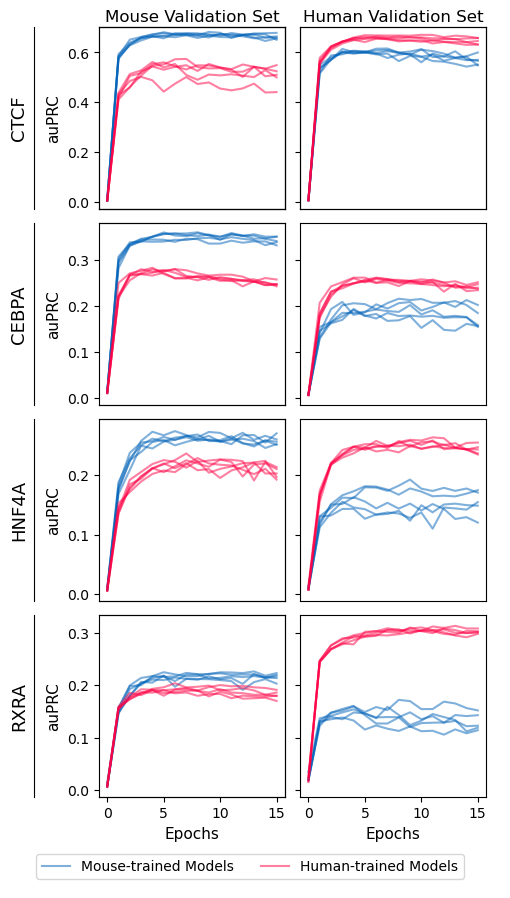

In [12]:
generate_all_auprc_plots(tfs, save_file = True)